# [CW2](https://www.cs.bris.ac.uk/Teaching/Resources/COMS21202/cw2/cw2.html)
## TODO
- Import train data
- Find features
- Feature selection
- Build classifier
- Show decision boundries
- Create test data
- Classify test data

## Potential features
- Edges
- Corners
- black pixel count
- texture detection using histograms
- Number of shapes (find joined shapes) e.g. 2 shapes likely an i
- width to height ratio of cropped image

**In Fourier Domain space**:
- rectangle at corner differentiate t and s
- calculate total magnitude in arc from centre with particular radius

## Reading list
- [A Fourier Descriptor Based Character Recognition Engine](http://cs.boisestate.edu/~tim/papers/spie-jared.pdf) - includes list of features
- [Character Recognition Using Fourier Descriptors](http://cs.boisestate.edu/~amit/mscs/samples/Jared_Hopkins_Project_Report.pdf) - Very long but good detail + experiments

In [439]:
import re
import copy
import glob
import scipy.misc
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
import numpy.fft
import scipy.ndimage
from skimage.morphology import skeletonize
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import  Axes3D 


%matplotlib inline
# notebook
import matplotlib.pylab as pylab
#pylab.rcParams['figure.figsize'] = (64.0, 48.0)

COLOURS_LOOKUP = {'S': 'blue', 'T': 'red', 'V': 'green'}
LABEL_LOOKUP = {'S': 0, 'T': 1, 'V': 2}

CMAP_LIGHT = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
CMAP_BOLD  = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

class prettyfloat(float):
    def __repr__(self):
        return "%0.3f" % self


In [412]:
# Read our images

# Read image and convert to binary
def load_img(filename):
    img = scipy.misc.imread(filename, flatten=True, mode='L')
    img[img == 255] = 1
    img = np.logical_not(img).astype(int)
    return img

# Show a binary image
def show_img(img, title=None):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    if title:
        plt.suptitle(title)
    plt.show()
    
def crop_img(img):        
    a = np.argwhere(img)
    (ystart, xstart), (ystop, xstop) = a.min(0), a.max(0) + 1 
    return img[ystart:ystop, xstart:xstop]

def erode_img(img):
    return scipy.ndimage.grey_erosion(img, size=(5,5))
    
# Calc magnitude spectrum
def calc_mag_spec(img):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    return 20*np.log(np.abs(fshift))

# Experiment 1, quadrant
def quadrants_slice(img):
    h, w = img.shape # TODO these may be in the wrong order
    
    top_left = img[:h/2,:w/2]
    top_right = img[:h/2,w/2:]
    bot_left = img[h/2:,:w/2]
    bot_right = img[h/2:,w/2:]
    
    return [top_left, top_right, bot_left, bot_right]

def centre_slices(img, h_ratio=8, w_ratio=8):
    h, w = img.shape
    return [img[h/2-h/h_ratio:h/2+h/h_ratio,:], img[:,w/2-w/w_ratio:w/2+w/w_ratio]]

def center_box(img, h_ratio=8, w_ratio=8):
    h, w = img.shape
    return img[h/2-h/h_ratio:h/2+h/h_ratio,w/2-w/w_ratio:w/2+w/w_ratio]


def centre_slices_exclude_centre(img, ch_ratio=8, cw_ratio=8, h_ratio=8, w_ratio=8):
    h, w = img.shape
    
    lr, ud = centre_slices(img, h_ratio, w_ratio)
    
    top   = ud[:h/2-h/ch_ratio,:]
    bot   = ud[h/2+h/ch_ratio:,:]
    left  = lr[:,:w/2-w/cw_ratio]
    right = lr[:,w/2+w/cw_ratio:]
    
    return [top, right, bot, left]

# http://stackoverflow.com/a/18354475
def sector_mask(shape,centre,radius,angle_range):
    """
    Return a boolean mask for a circular sector. The start/stop angles in  
    `angle_range` should be given in clockwise order.
    """

    x,y = np.ogrid[:shape[0],:shape[1]]
    cx,cy = centre
    tmin,tmax = np.deg2rad(angle_range)

    # ensure stop angle > start angle
    if tmax < tmin:
            tmax += 2*np.pi

    # convert cartesian --> polar coordinates
    r2 = (x-cx)*(x-cx) + (y-cy)*(y-cy)
    theta = np.arctan2(x-cx,y-cy) - tmin

    # wrap angles between 0 and 2*pi
    theta %= (2*np.pi)

    # circular mask
    circmask = r2 <= radius*radius

    # angular mask
    anglemask = theta <= (tmax-tmin)

    return circmask*anglemask

def sector(img, radius=50, angle_range=(200, 250)):
    h, w = img.shape
    
    mask = sector_mask(img.shape,(h/2,w/2), radius, angle_range)
    
    img_c = img.copy()
    img_c[~mask] = 0
    return img_c
  
# Helper function to calculate means of a list of lists
def means(items):
    return [np.mean(item) for item in items]

# Helper function to calculate spread of list
def spread(items):
    return np.max(items) - np.min(items)

In [443]:
class Character():
    def __init__(self, filename, label=None, filename_id=None, crop=False, skel=True):
        self.filename = filename
        self.label    = label
        self.filename_id = filename_id
        self.features = {}
        self.cropped = crop
        self.skeleton = skel
        
        img = load_img(filename)
        if crop:
            img = crop_img(img)
            
        if skel:
            img = skeletonize(img)
            
        self.img      = img
        self.spec     = calc_mag_spec(self.img)
        
        self._compute_features()
        
        if type(self.label) == str:
            self.label = self.label.upper()
        
    def show(self):
        show_img(self.img)
        
    def show_spec(self):
        show_img(self.spec)
        
    def _compute_features(self):
        mean = np.mean(self.spec)
        self.features['mean'] = mean

        css = centre_slices(self.spec)
        css_means = means(css)
        css_spread = spread(css_means)
        for i, m in enumerate(css_means):
            self.features['centre_slices_mean_%i' % i] = m
            #break
        self.features['centre_slices_spread'] = css_spread

        cssec = centre_slices_exclude_centre(self.spec, h_ratio=30, w_ratio=30)
        cssec_means = means(cssec)
        cssec_spread = spread(cssec_means)
        for i, m in enumerate(cssec_means):
            self.features['centre_slice_ex_centre_means_%i' % i] = m
            
        self.features['centre_slice_ex_centre_spread'] = cssec_spread

        cb = center_box(self.spec)
        cb_mean = np.mean(cb)
        cb_quads = quadrants_slice(cb)
        cb_quads_means = means(cb_quads)
        cb_quads_spread = spread(cb_quads_means)
        self.features['centre_mean'] = cb_mean
        for i, m in enumerate(cb_quads_means):
            self.features['centre_quads_means_%i' % i] = m
            #break
        self.features['centre_quads_spread'] = cb_quads_spread

        quads = quadrants_slice(self.spec)
        quad_means = means(quads)
        for i, m in enumerate(quad_means):
            self.features['quad_means_%i' % i] = m
            #break
            
        self.features['diaginal_mean'] = np.mean(self.spec * np.eye(self.spec.shape[0], self.spec.shape[1]))
        
        self.features['tl_quad_sector_mean'] = np.mean(sector(self.spec))
        
        
    def print_features(self):
        print self.filename_id
        for key, val in self.features.items():
            v = val
            if type(val) == list:
                v = str(map(prettyfloat, val))
            elif type(val) == float or type(val) == np.float64:
                v = "%.3f" % val
            elif type(val) == int:
                v = "%i" % val
                
            print "\t%s: %s" % (key, v)
        
    def show_with_spec(self):
        fig = plt.figure()
        ax = fig.add_subplot(1, 2, 1)
        plt.imshow(self.img, cmap='gray')
        ax = fig.add_subplot(1, 2, 2)
        plt.imshow(self.spec, cmap='gray')
        
        plt.tight_layout()
        plt.show()
        
    def __repr__(self):
        return str(self.label)
        
class Dataset():
    def __init__(self, dataset):
        self.dataset = dataset
    
    def label_is(self, label):
        return Dataset([c for c in self.dataset if c.label == label.upper()])
    
    def unique_labels(self):
        labels = []
        [labels.append(c.label) for c in self.dataset]
        return list(set(labels))
    
    def unique_labels_ds(self):
        return [self.__getitem__(l) for l in self.unique_labels()]
    
    def select_features(self, features):
        d = copy.deepcopy(self.dataset)
        for c in d:
            cf = {}
            for f in features:
                cf[f] = c.features[f]
            c.features = cf
            
        return Dataset(d)
    
    def features(self):
        return self.dataset[0].features
    
    def feature(self, feature):
        return [c.features[feature] for c in self.dataset]
    
    def xy(self, features=[]):
        X = []
        Y = []
        if features == []:
            names = self.features()
        else:
            names = features
            
        for c in self.dataset:
            if features == []:
                X.append(c.features.values())
            else:
                X.append([c.features[f] for f in features])
            Y.append(LABEL_LOOKUP[c.label])
        
        return (np.array(X), np.array(Y), names)
    
    def show(self):        
        fig = plt.figure()
        for i, c in enumerate(self.dataset, start=1):
            ax = fig.add_subplot(len(self.dataset), 1, i)
            plt.imshow(c.img, cmap='gray')
            ax.axis('off')
            ax.set_title(c.filename_id)
        
        plt.tight_layout()
        plt.show()
        
    def show_with(self, f, title=''):
        fig = plt.figure()     
        for i, c in enumerate(self.dataset):
            ax = fig.add_subplot(len(self.dataset), 2, i*2+1)
            plt.imshow(c.img, cmap='gray')
            ax.axis('off')
            ax.set_title(c.filename_id)
            
            ax = fig.add_subplot(len(self.dataset), 2, i*2+2)
            plt.imshow(f(c.img), cmap='gray')
            ax.axis('off')
            ax.set_title('%s %s' % (c.filename_id, title))
            
        plt.tight_layout()
        plt.subplots_adjust(right=0.3)
        plt.show()
        
    def show_with_spec(self):
        self.show_with()
        fig = plt.figure()     
        for i, c in enumerate(self.dataset):
            ax = fig.add_subplot(len(self.dataset), 2, i*2+1)
            plt.imshow(c.img, cmap='gray')
            ax.axis('off')
            ax.set_title(c.filename_id)
            
            ax = fig.add_subplot(len(self.dataset), 2, i*2+2)
            plt.imshow(c.spec, cmap='gray')
            ax.axis('off')
            ax.set_title('%s magnitude spectrum' % c.filename_id)
            
        plt.tight_layout()
        plt.subplots_adjust(right=0.3)
        plt.show()
        
    def compare_features(self, fs):
        assert len(fs) >= 2
        assert len(fs) <= 3
        
        fig = plt.figure()
        
        if len(fs) == 3:
            ax = Axes3D(fig)
            ax.set_title('%s - %s - %s' % (fs[0], fs[1], fs[2]))   
        else:
            ax = plt.subplot()
            ax.set_title('%s - %s' % (fs[0], fs[1]))
         
        X, y, _ = self.xy(fs)
        if len(fs) == 3:
            ax.scatter(X[:,0], X[:,1], X[:,2], c=y, cmap=CMAP_BOLD)
        else:
            ax.scatter(X[:,0], X[:,1], c=y, cmap=CMAP_BOLD)
        
        plt.show()
    
    def append(self, character):
        self.dataset.append(character)
        return self
    
    def __iter__(self):
        return iter(self.dataset)
    
    def __len__(self):
        return len(self.dataset)
    
    def __contains__(self, x):
        return x in self.dataset
    
    def __setitem__(self, key, value):
        self.dataset[key] = value
        
    def __getitem__(self, key):
        if type(key) == int:
            return self.dataset[key]
        elif type(key) == str:
            if len(key) == 1:
                return self.label_is(key)
            else:
                i = self.key_by_fid(key)
                if i is not None:
                    return self.dataset[i]
                else:
                    raise IndexError('unknown key %s' % key)
        elif type(key) == slice:
            return Dataset(self.dataset[key])
        else:
            raise IndexError('unknown key %s' % key)
            
    def key_by_fid(self, filename_id):
        for i, c in enumerate(self.dataset):
            if c.filename_id == filename_id.upper():
                return i
        return None
    
    def __delitem__(self, key):
        if type(key) == str:
            key = self.key_by_fid(key)

        del self.dataset[key]    
        
    def __repr__(self):
        return "".join([c.label for c in self.dataset])
    
    

In [444]:
# Load training dataset
def load_data(path):
    dataset = Dataset([])
    for filename in glob.glob(path):
        m = re.search(r"\/([a-z])([0-9]+)\.GIF", filename, re.IGNORECASE)
        label = None
        filename_id = None
        if m:
            label =  m.group(1)
            filename_id = "%s%s" % (label, m.group(2))
        dataset.append(Character(filename, label=label, filename_id=filename_id, crop=False, skel=True))
    return dataset

train_dataset = load_data('characters_data/*.GIF')
# Remove A1 & B1 for now
del train_dataset['A1'] 
del train_dataset['B1']

#train_dataset['S'].show_with(skeletonize, 'skel')

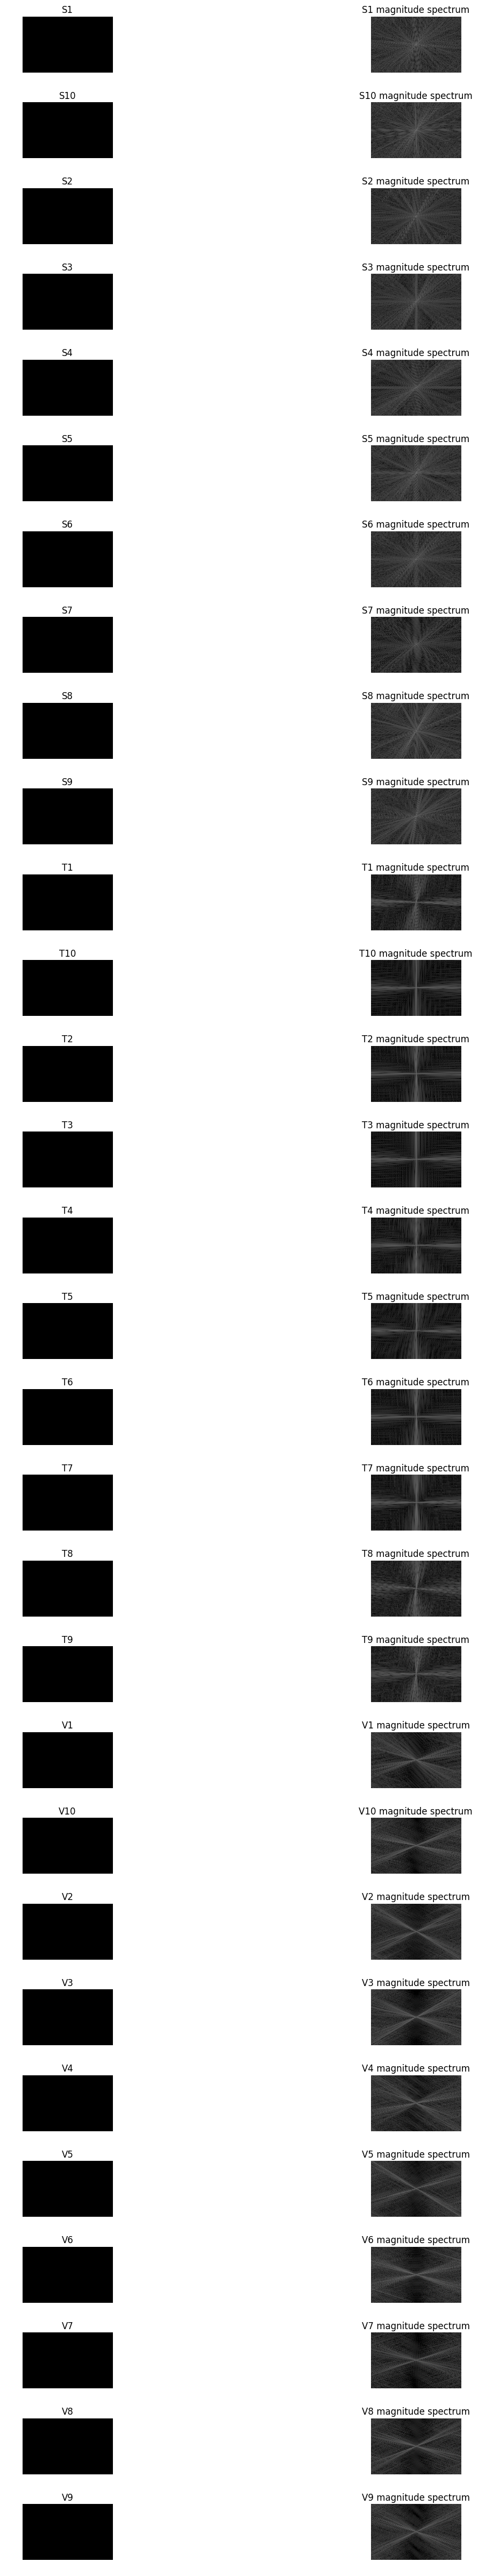

In [267]:
# Show the spectrums
train_dataset.show_with_spec()

In [265]:
for c in train_dataset:
    c.print_features()

S1
	diaginal_mean: 0.087
	tl_quad_sector_mean: 0.300
	centre_mean: 69.756
	quad_means_0: 54.549
	centre_quads_spread: 2.523
	centre_slice_ex_centre_spread: 0.426
	centre_slices_mean_0: 60.042
	centre_slice_ex_centre_means_1: 58.822
	centre_slice_ex_centre_means_0: 58.525
	centre_slices_spread: 0.269
	centre_slice_ex_centre_means_2: 58.572
	centre_slice_ex_centre_means_3: 58.951
	centre_quads_means_0: 68.386
	mean: 55.652
S10
	diaginal_mean: 0.090
	tl_quad_sector_mean: 0.298
	centre_mean: 70.567
	quad_means_0: 55.330
	centre_quads_spread: 6.333
	centre_slice_ex_centre_spread: 4.728
	centre_slices_mean_0: 59.945
	centre_slice_ex_centre_means_1: 61.865
	centre_slice_ex_centre_means_0: 66.338
	centre_slices_spread: 3.598
	centre_slice_ex_centre_means_2: 66.574
	centre_slice_ex_centre_means_3: 61.845
	centre_quads_means_0: 67.269
	mean: 56.995
S2
	diaginal_mean: 0.085
	tl_quad_sector_mean: 0.297
	centre_mean: 66.523
	quad_means_0: 51.967
	centre_quads_spread: 2.401
	centre_slice_ex_centre_s

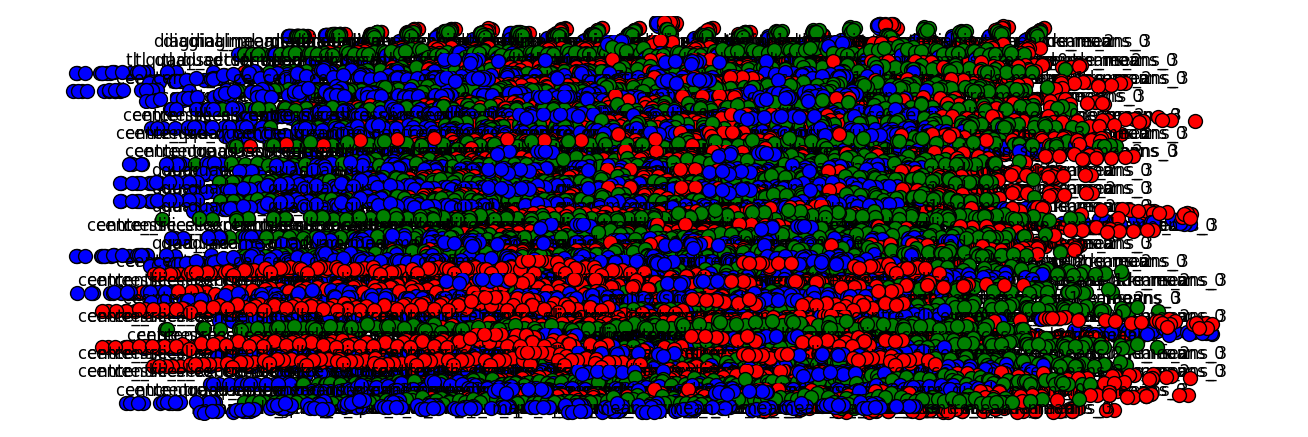

In [405]:
# Feature selection
fig = plt.figure()
useable_features = [k for k,v in train_dataset[0].features.items() if type(v) != list]
pid = 1

for x, k1 in train_dataset.features():
    for y, k2 in enumerate(useable_features):
        ax = fig.add_subplot(len(useable_features), len(useable_features), pid)
         
        for d in train_dataset.unique_labels_ds():
            ax.scatter(d.feature(k1), d.feature(k2), s=100, c=COLOURS_LOOKUP[d.unique_labels()[0]])
        
        pid += 1
        ax.axis('off')
        ax.set_title('%s - %s' % (k1, k2))
    
plt.tight_layout()
plt.show()    

Optimal number of features : 2
Selected features: ['centre_slice_ex_centre_means_2', 'centre_quads_means_0']


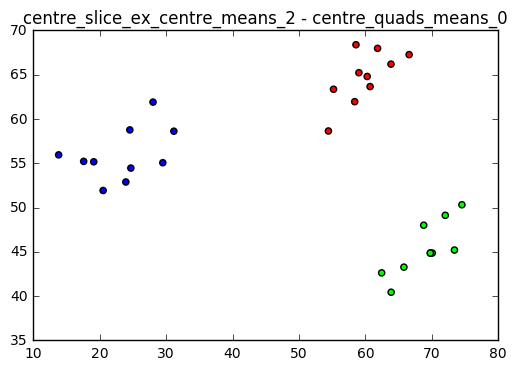

In [445]:
from sklearn.svm import SVC
from sklearn.feature_selection import RFE, RFECV

X, Y, names = train_dataset.xy()

# Create the RFE object and compute a cross-validated score.
svc = SVC(kernel="linear")

rfecv = RFECV(estimator=svc, step=1, cv=3, scoring='accuracy')
rfecv.fit(X, Y)

selected_features = [names[i] for i, s in enumerate(rfecv.support_) if s]
print("Optimal number of features : %d" % rfecv.n_features_)
print("Selected features: %s" % selected_features)

train_dataset.compare_features(selected_features)

In [446]:
# Recreate the dataset with only the selected features
train_dataset = train_dataset.select_features(selected_features)
X, Y, names = train_dataset.xy()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(X, Y)

x_min, x_max = X[:, 0].min() - 10, X[:, 0].max() + 10
y_min, y_max = X[:, 1].min() - 10, X[:, 1].max() + 10
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

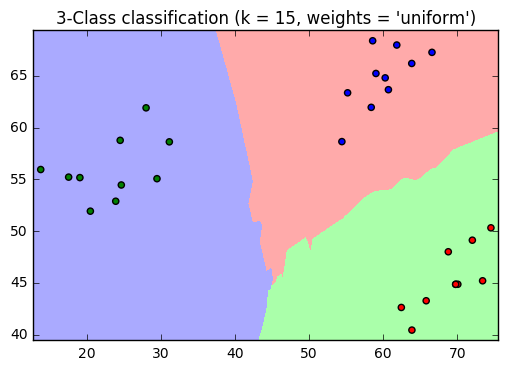

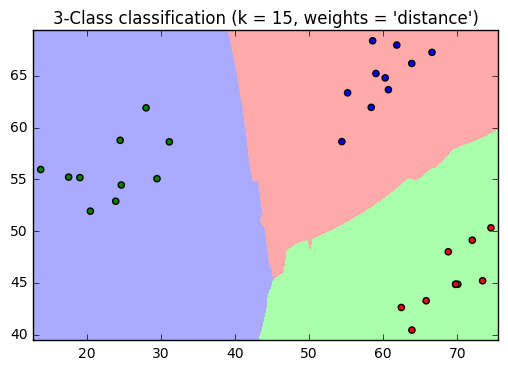

In [436]:
from matplotlib.colors import ListedColormap
from sklearn import neighbors

n_neighbors = 15

h = .02  # step size in the mesh

# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X, Y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # COLOURS_LOOKUP = {'S': 'blue', 'T': 'red', 'V': 'green'}
    # LABEL_LOOKUP = {'S': 0, 'T': 1, 'V': 2}
    
    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=Y, cmap=ListedColormap(COLOURS_LOOKUP.values()))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title("3-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))

plt.show()